<img src="../../code/Resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Dataset Exercises</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.6: Does the behavior state have different manifestations in different brain regions? </b>
<p> In the workshop today, we found two ways to define behavior state (an inutitive and an algorhmic approach). We also saw that the activity of some neurons is dependent upon the behavior state. This leads us to the question: which brain regions have the most cells which are sensitive to the behavior states that we found?
<p> A simple question we can ask: are cells preferentially behavior state dependent the deeper you go? Do more superficial layers care less about the behavior state of the animal?
<div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Import the datapath and load the data
<div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

pd.set_option('display.max_columns', None)

%matplotlib inline

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [2]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache_dir  = data_root

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=cache_dir, use_static_cache=True)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Choose the example sessions
<div>

In [5]:
example_sessions = [1139846596, 1124507277, 1069461581]

session_id = example_sessions[0] 
session = cache.get_ecephys_session(session_id)

trial_metadata = session.trials # 'trials' is a dataframe that contains metadata and task information for each trial

display(trial_metadata.iloc[10:20].head()) # to do: add precomputed response time? 

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
10,68.21075,76.23431,im114_r,im024_r,True,71.96442,False,False,"[72.581, 72.68075, 72.78081, 72.8976, 73.01423...",72.58100,72.13147,0.005,False,False,False,False,False,True,2716.0,8.02356
11,76.46747,79.43677,im024_r,im024_r,False,NaN,False,False,[79.12019],NaN,NaN,0.000,False,False,False,False,True,False,NaN,2.96930
12,79.47013,81.13830,im024_r,im024_r,False,NaN,False,False,"[80.67133, 80.82089]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,1.66817
13,81.72219,88.97824,im024_r,im104_r,True,84.72478,True,False,"[85.22592, 85.3412, 85.44124, 85.52476, 85.624...",85.22592,85.22592,0.003,True,False,False,False,False,False,3481.0,7.25605
14,89.22820,93.11532,im104_r,im104_r,False,NaN,False,False,"[92.64816, 92.79754]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,3.88712


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Load the probes and the unit data.
<div>

In [6]:
probe_id = session.probes[session.probes.name == 'probeA'].index.values
unit_table = session.get_units(probe_id, amplitude_cutoff_maximum = 0.1, 
                               presence_ratio_minimum = 0.9, isi_violations_maximum = 0.5) # to do: this table does not include ccf location. 
unit_table = cache.get_unit_table().loc[unit_table.index.values] 

unit_table.value_counts('structure_acronym')

structure_acronym
CA1      185
VISp      88
VISpm     64
VISam     63
VISal     56
VISl      55
DG        52
MGv       47
CA3       46
PIL       41
VISrl     39
SUB       29
APN       25
ProS      21
MB        16
SCig      14
TH        12
MGm        9
PoT        8
LP         7
MGd        3
MRN        1
dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Define the engaged versus disengaged state from our workshop
<div>

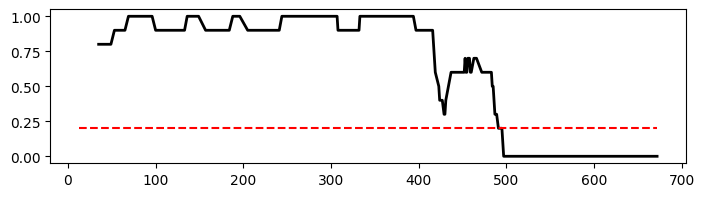

In [12]:
engagement_threshold = 0.2
go_trials =  trial_metadata[trial_metadata.go].index
hit_rate = trial_metadata.hit[trial_metadata.go].rolling(10).mean()
num_go_trials = go_trials.shape[0]

fig,ax = plt.subplots(figsize = (8.2, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials, engagement_threshold*np.ones(num_go_trials), color = 'r', ls = '--')

# Determine state transition boundaries
states = hit_rate < engagement_threshold
switch_trials = np.where(np.diff(states.values))[0]
switch_trials = np.concatenate(([0], switch_trials, [num_go_trials-1]))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Extract the unit spikes
<div>

In [13]:
unit = 1153690093
unit_data = session.spike_times[unit]

# define the all the trials that we want to study
start_times = trial_metadata.start_time
stop_times = trial_metadata.stop_time

spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
spike_rate = [float(spike_times[a].shape[0])/(stop_times[i]-start_times[i]) for a, i in enumerate(start_times.index)]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Use the "probe_vertical_positions" to define the depth of the unit. 
<div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Define the average in the cells firing rate across each trial. Then aggregate this  trial mean firing rate into engaged and disengaged trials. How much does each units mean firing rate change between these two behavior states?
<div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Plot the dynamics across the 
<div>

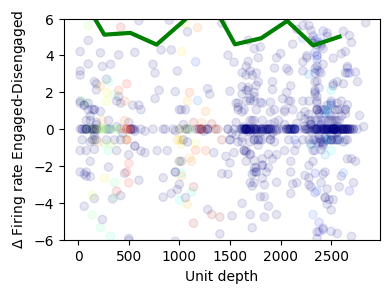

In [14]:
area_of_interest = ['VISam', 'TH', 'DG', 'MGv'] # looking for regions with enhanced behavior state sensitivity
unit_nos = np.array([idx for idx, ccf in enumerate(unit_table.structure_acronym.values) if ccf in area_of_interest])
unit_ids = unit_table.index[unit_nos] 

# extract the sample unit ids and ready our three lists for recording values
example_unit_ids = unit_table.index
engaged_firing_rate_difference = []
unit_depth = []
in_region = []

# loop through all units
for n, unit in enumerate(example_unit_ids):
    unit_data = session.spike_times[unit]
    spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    
    # Compute the firing rate for each trial
    firing_rate = [len(spikes)/(s2 - s1) for spikes, s1, s2 in zip(spike_times, start_times, stop_times)]
    
    # compute the firing rate in both the engaged and disengaged trials
    engaged_firing_rate = []
    disengaged_firing_rate = []
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            engaged_firing_rate.append(firing_rate[i])
        else:
            disengaged_firing_rate.append(firing_rate[i])
            
    # identify if unit is in the your CCF.
    if unit in unit_ids:
        in_region.append(np.where(unit == np.array(unit_ids))[0][0])
    else:
        in_region.append(0)
    # Calculate the difference in firing rate for that unit between behavior states.
    engaged_firing_rate_difference.append((np.mean(engaged_firing_rate) - np.mean(disengaged_firing_rate)))
    unit_depth.append(unit_table.loc[unit].probe_vertical_position)

    
# make plot and prepare bins
fig,ax = plt.subplots(1,1, figsize = (4,3))    
NumBins = 12
bins = np.linspace(0, np.max(unit_depth), NumBins)
variance_at_depth = np.zeros([NumBins-1, 1])
for bin_idx in range(NumBins-1):
    keep_in_bin = np.logical_and(np.array(unit_depth) > bins[bin_idx], np.array(unit_depth) < bins[bin_idx + 1])
    variance_at_depth[bin_idx] = np.std(np.array(engaged_firing_rate_difference)[keep_in_bin])

ax.scatter(unit_depth, engaged_firing_rate_difference, c=in_region, alpha=0.1, cmap='jet')
ax.plot(bins[0:-1], variance_at_depth, 'g', lw=3)
#ax.set_xlim([0,1])
ax.set_ylim([-8,8])
ax.set_xlabel('Unit depth')
ax.set_ylabel('$\Delta$ Firing rate Engaged-Disengaged')
plt.tight_layout()
plt.show()

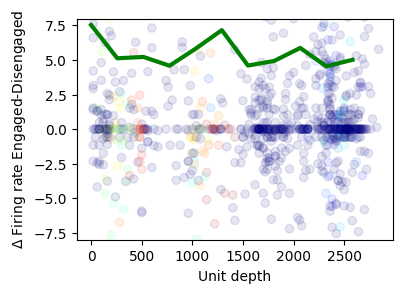

In [16]:
fig,ax = plt.subplots(1,1, figsize = (4,3)) 
ax.scatter(unit_depth, engaged_firing_rate_difference, c=in_region, alpha=0.1, cmap='jet')
ax.plot(bins[0:-1], variance_at_depth, 'g', lw=3)
#ax.set_xlim([0,1])
ax.set_ylim([-8,8])
ax.set_xlabel('Unit depth')
ax.set_ylabel('$\Delta$ Firing rate Engaged-Disengaged')
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In this simple study, we find that the response difference in firing rate of neurons across depth is seems to grow with depth. How could you validate this result with other data that you've seen? 
    
<p> Is this consistent with the thamlo-cortical loops which are often associated with being behavior state dependent?
</div>